In [1]:
from ucimlrepo import fetch_ucirepo
from dataclasses import dataclass
from typing import List, Tuple, Dict, Union
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, gaussian_kde
from data_generator.main import generate_data
from sklearn.preprocessing import LabelEncoder


def is_numeric_column(series: pd.Series) -> bool:
    """
    Check if a column should be treated as numeric for KDE.
    """
    if not np.issubdtype(series.dtype, np.number):
        return False

    n_unique = len(series.dropna().unique())
    return n_unique >= 5


def is_integer_column(series: pd.Series) -> bool:
    """
    Check if a numeric column contains only integers.
    """
    return np.all(series.dropna() == series.dropna().astype(int))


def get_unique_samples(kde: gaussian_kde, n_samples: int, is_integer: bool = False,
                       max_attempts: int = 1000) -> np.ndarray:
    """
    Get unique samples from KDE with appropriate type handling.
    """
    samples = kde.resample(min(n_samples * 2, max_attempts))[0]

    if is_integer:
        samples = np.round(samples).astype(int)

    unique_samples = np.unique(samples)

    attempts = 1
    while len(unique_samples) < n_samples and attempts < max_attempts:
        new_samples = kde.resample(n_samples)[0]
        if is_integer:
            new_samples = np.round(new_samples).astype(int)
        unique_samples = np.unique(np.concatenate([unique_samples, new_samples]))
        attempts += 1

    if len(unique_samples) > n_samples:
        indices = np.linspace(0, len(unique_samples) - 1, n_samples).astype(int)
        unique_samples = np.sort(unique_samples)[indices]

    return unique_samples


@dataclass
class DataSchema:
    attr_categories: List[List[Union[int, float]]]  # Now starts from 0
    protected_attr: List[str]
    attr_names: List[str]
    category_maps: Dict[str, Dict[Union[int, float], str]]


def create_kde_encoding(series: pd.Series, n_samples: int = 100) -> Tuple[
    np.ndarray, gaussian_kde, List[Union[int, float]], Dict[Union[int, float], str]]:
    """
    Create KDE from the series and sample fixed points from it.
    """
    non_nan_mask = pd.notna(series)
    values = series[non_nan_mask].to_numpy()

    if len(values) == 0:
        return np.full(len(series), -1), None, [-1, 0], {-1: 'nan', 0: '0'}

    kde = gaussian_kde(values)
    is_integer = is_integer_column(series)
    sampled_points = get_unique_samples(kde, n_samples, is_integer)

    # Create categories starting from -1 (missing) then 0 to n-1
    categories = [-1] + list(range(len(sampled_points)))

    # Create mapping dictionary
    if is_integer:
        category_map = {-1: 'nan',
                        **{i: str(int(point)) for i, point in zip(range(len(sampled_points)), sampled_points)}}
    else:
        category_map = {-1: 'nan',
                        **{i: f"{point:.3f}" for i, point in zip(range(len(sampled_points)), sampled_points)}}

    # Encode original values
    encoded = np.full(len(series), -1)  # Default to -1 for missing values
    for i, val in enumerate(series[non_nan_mask]):
        nearest_idx = np.abs(sampled_points - val).argmin()
        encoded[non_nan_mask][i] = nearest_idx  # Now starts from 0

    return encoded, kde, categories, category_map


def generate_schema_from_dataframe(
        df: pd.DataFrame,
        protected_columns: List[str] = None,
        attr_prefix: str = None,
        outcome_column: str = 'outcome',
        ensure_positive_definite: bool = True,
        n_samples: int = 100
) -> Tuple[DataSchema, np.ndarray]:
    """
    Generate a DataSchema and correlation matrix from a pandas DataFrame using KDE for numeric columns.
    """
    if outcome_column not in df.columns:
        raise ValueError(f"Outcome column '{outcome_column}' not found in DataFrame")

    if attr_prefix:
        attr_columns = [col for col in df.columns if col.startswith(attr_prefix)]
    else:
        attr_columns = [col for col in df.columns if col != outcome_column]

    if not attr_columns:
        raise ValueError("No attribute columns found")

    attr_categories = []
    encoded_df = pd.DataFrame(index=df.index)
    binning_info = {}
    kde_distributions = {}
    label_encoders = {}
    category_maps = {}

    for col in attr_columns:
        if is_numeric_column(df[col]):
            encoded_vals, kde, categories, category_map = create_kde_encoding(df[col], n_samples)

            encoded_df[col] = encoded_vals
            attr_categories.append(categories)  # Now contains [-1, 0, 1, ..., n-1]
            category_maps[col] = category_map

            if kde is not None:
                kde_distributions[col] = kde
                binning_info[col] = {
                    'strategy': 'kde',
                    'n_samples': n_samples,
                    'is_integer': is_integer_column(df[col])
                }

        else:
            le = LabelEncoder()
            non_nan_vals = df[col].dropna().unique()

            if len(non_nan_vals) > 0:
                str_vals = [str(x) for x in non_nan_vals]
                str_vals = list(dict.fromkeys(str_vals))

                le.fit(str_vals)
                encoded = np.full(len(df), -1)  # Default to -1 for missing values

                mask = df[col].notna()
                if mask.any():
                    encoded[mask] = le.transform([str(x) for x in df[col][mask]])  # Now starts from 0

                # Store encoded categories and mapping
                categories = [-1] + list(range(len(str_vals)))  # [-1, 0, 1, ..., n-1]
                category_map = {-1: 'nan', **{i: val for i, val in enumerate(str_vals)}}

                label_encoders[col] = le
                category_maps[col] = category_map
            else:
                encoded = np.full(len(df), -1)
                categories = [-1, 0]  # Always include 0 even if empty
                category_map = {-1: 'nan', 0: 'empty'}

            encoded_df[col] = encoded
            attr_categories.append(categories)

    # Rest of the function remains the same...
    if protected_columns is None:
        protected_attr = [False] * len(attr_columns)
    else:
        invalid_cols = [col for col in protected_columns if col not in attr_columns]
        if invalid_cols:
            raise ValueError(f"Protected columns {invalid_cols} not found in attributes")
        protected_attr = [col in protected_columns for col in attr_columns]

    correlation_matrix = np.zeros((len(attr_columns), len(attr_columns)))
    for i, col1 in enumerate(attr_columns):
        for j, col2 in enumerate(attr_columns):
            if i == j:
                correlation_matrix[i, j] = 1.0
            else:
                # Update mask to check for non-zero values
                mask = (encoded_df[col1] > 0) & (encoded_df[col2] > 0)
                if mask.any():
                    corr, _ = spearmanr(encoded_df[col1][mask], encoded_df[col2][mask])
                    correlation_matrix[i, j] = corr if not np.isnan(corr) else 0.0
                    correlation_matrix[j, i] = correlation_matrix[i, j]
                else:
                    correlation_matrix[i, j] = 0.0
                    correlation_matrix[j, i] = 0.0

    if ensure_positive_definite:
        eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)
        if np.any(eigenvalues < 0):
            eigenvalues[eigenvalues < 0] = 1e-6
            correlation_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
            scaling = np.sqrt(np.diag(correlation_matrix))
            correlation_matrix = correlation_matrix / scaling[:, None] / scaling[None, :]

    schema = DataSchema(
        attr_categories=attr_categories,
        protected_attr=protected_attr,
        attr_names=attr_columns,
        category_maps=category_maps
    )

    return schema, correlation_matrix


def decode_dataframe(df: pd.DataFrame, schema: DataSchema) -> pd.DataFrame:
    """
    Decode a dataframe using the schema's category maps.
    """
    decoded_df = pd.DataFrame(index=df.index)

    for col in schema.attr_names:
        if col in df.columns:
            category_map = schema.category_maps[col]
            decoded_df[col] = df[col].map(lambda x: category_map.get(x, category_map[0]))

    return decoded_df


In [ ]:
adult = fetch_ucirepo(id=2)
df1 = adult['data']['original']
df1.drop(columns=['fnlwgt'], inplace=True)

In [3]:
schema, corr_matrix = generate_schema_from_dataframe(df1, protected_columns=['race', 'sex'], outcome_column='income',
                                                     n_samples=50)

In [14]:
corr_matrix.shape

(13, 13)

In [4]:
data = generate_data(
    correlation_matrix=corr_matrix,
    data_schema=schema,
    prop_protected_attr=0.4,
    nb_groups=10,
    max_group_size=400,
    categorical_outcome=True,
    use_cache=False,
    corr_matrix_randomness=1.0)

print(f"Generated {len(data.dataframe)} samples in {data.nb_groups} groups")
print(f"Collisions: {data.collisions}")

df2 = decode_dataframe(data.dataframe, schema)
print('ddd')

Generating data: 100%|██████████| 10/10 [00:00<00:00, 28.64it/s]


Generated 2162 samples in 10 groups
Collisions: 0
ddd


In [30]:
data.dataframe

,age,workclass,education,education-num,marital-status,occupation,relationship,capital-gain,capital-loss,hours-per-week,...,calculated_aleatoric,calculated_similarity,calculated_epistemic_group,calculated_aleatoric_group,calculated_magnitude,calculated_uncertainty_group,calculated_intersectionality,calculated_granularity,calculated_group_size,calculated_subgroup_ratio
1411,0,6,7,9,4,10,5,2,1,3,...,0.090001,0.000000,0.057061,0.057278,0.236813,0.05717,1.0,0.090909,131,0.045273
1412,0,9,8,2,7,13,1,5,1,6,...,0.059025,0.000000,0.057061,0.057278,0.236813,0.05717,1.0,0.090909,131,0.045273
1361,10,6,13,11,7,14,4,3,1,36,...,0.028478,0.000000,0.057061,0.057278,0.236813,0.05717,1.0,0.090909,131,0.045273
1367,10,6,14,11,5,3,0,4,1,9,...,0.076920,0.000000,0.057061,0.057278,0.236813,0.05717,1.0,0.090909,131,0.045273
1370,10,6,15,14,3,5,2,4,1,17,...,0.104942,0.000000,0.057061,0.057278,0.236813,0.05717,1.0,0.090909,131,0.045273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,37,3,4,14,7,4,5,3,1,28,...,0.030870,0.666667,0.015541,0.031280,0.311623,0.02341,0.5,1.000000,219,0.168326
1789,37,3,4,14,7,4,5,3,1,28,...,0.030870,0.666667,0.015541,0.031280,0.311623,0.02341,0.5,1.000000,219,0.168326
1809,37,3,4,14,7,4,5,3,1,28,...,0.030870,0.666667,0.015541,0.031280,0.311623,0.02341,0.5,1.000000,219,0.168326
1795,37,3,4,14,7,4,5,4,1,28,...,0.027457,0.666667,0.015541,0.031280,0.311623,0.02341,0.5,1.000000,219,0.168326


In [13]:
df2.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_value_counts(df, figsize=(15, 10), max_categories=10, plot_style='bar'):
    # Calculate number of rows and columns for subplots
    n_cols = 2
    n_rows = (len(df.columns) + 1) // 2

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Value Counts Distribution by Column', fontsize=16, y=1.02)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    for idx, column in enumerate(df.columns):
        # Get value counts
        value_counts = df[column].value_counts()

        # Group small categories if there are too many
        if len(value_counts) > max_categories:
            other_sum = value_counts[max_categories:].sum()
            value_counts = value_counts[:max_categories]
            value_counts['Other'] = other_sum

        if plot_style == 'pie':
            value_counts.plot(kind='pie', ax=axes[idx], autopct='%1.1f%%')
            axes[idx].set_title(f'{column} Distribution')
        else:
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[idx])
            axes[idx].set_title(f'{column} Value Counts')
            axes[idx].tick_params(axis='x', rotation=45)

    # Remove any empty subplots
    for idx in range(len(df.columns), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    return fig

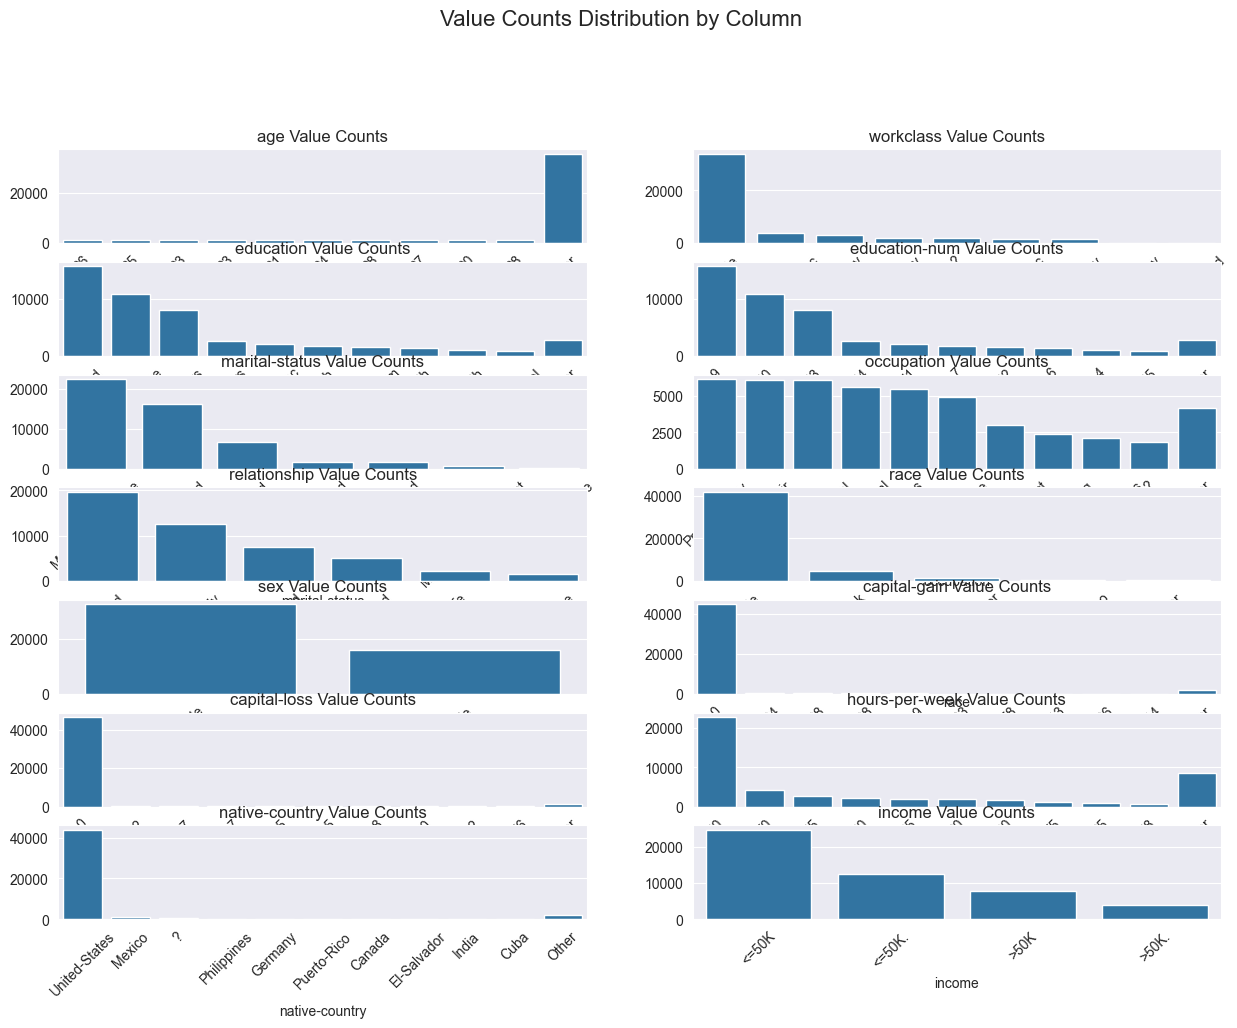

In [6]:
fig = plot_value_counts(df1)
plt.show()

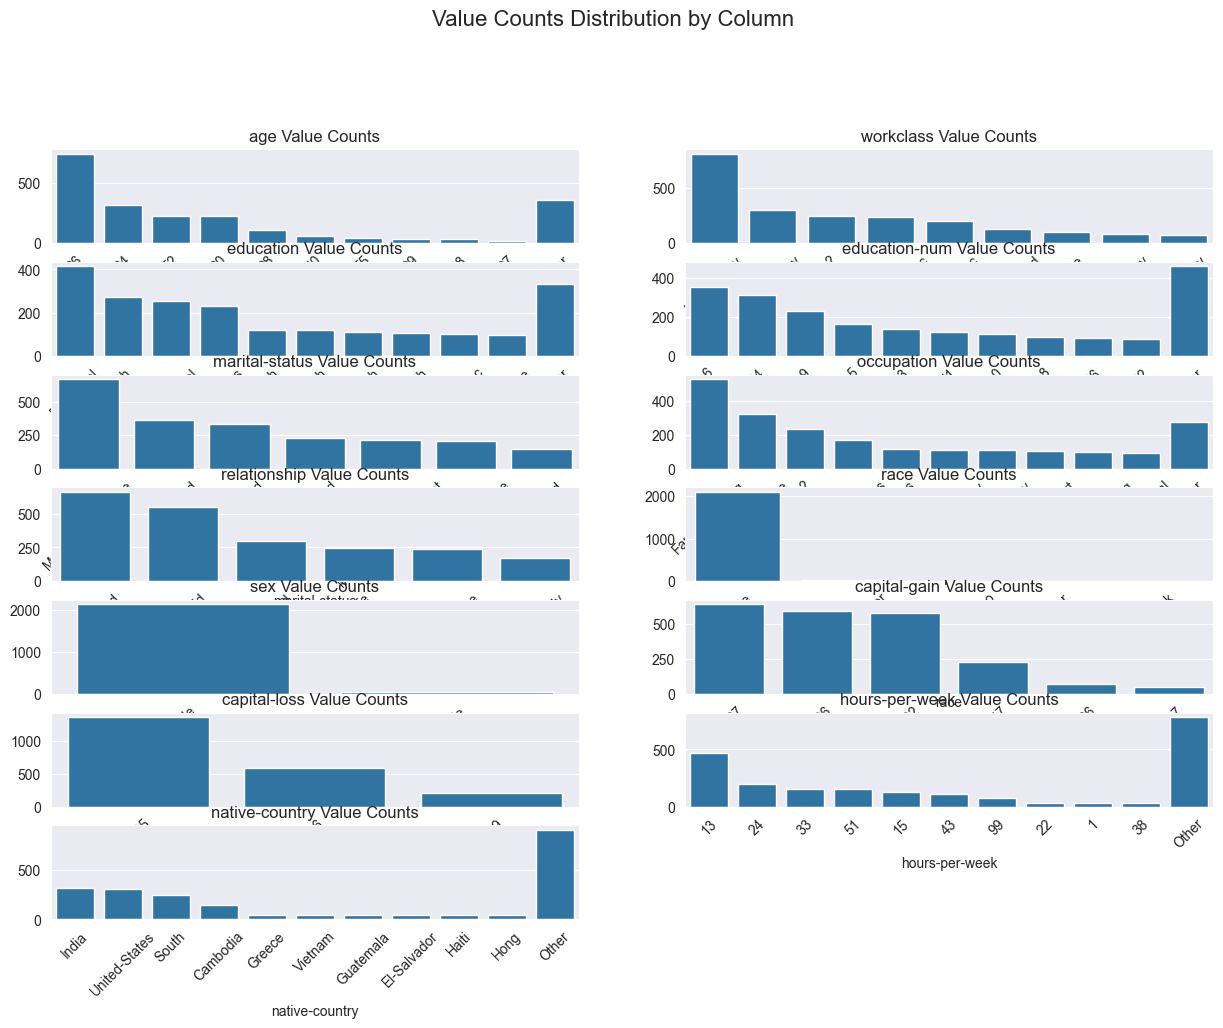

In [7]:
fig = plot_value_counts(df2)
plt.show()

In [33]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import cosine

def plot_correlation_matrices(input_correlation_matrix, gen_data, figsize=(30, 10)):
    attr_columns = [col for col in gen_data.dataframe.columns if col in list(df1.columns)]
    generated_correlation_matrix = gen_data.dataframe[attr_columns].corr(method='spearman')
    
    assert input_correlation_matrix.shape == generated_correlation_matrix.shape, "Correlation matrices have different shapes"
    
    if isinstance(input_correlation_matrix, np.ndarray):
        input_correlation_matrix = pd.DataFrame(input_correlation_matrix, columns=attr_columns, index=attr_columns)
    
    # Calculate similarity metrics
    frobenius = np.linalg.norm(input_correlation_matrix - generated_correlation_matrix)
    cosine_sim = 1 - cosine(input_correlation_matrix.values.flatten(), 
                           generated_correlation_matrix.values.flatten())
    mse = np.mean((input_correlation_matrix - generated_correlation_matrix) ** 2)
    correlation = np.corrcoef(input_correlation_matrix.values.flatten(), 
                            generated_correlation_matrix.values.flatten())[0,1]
    
    # Calculate the absolute difference matrix
    abs_diff_matrix = np.abs(input_correlation_matrix - generated_correlation_matrix)
    
    # Create custom colormap
    colors = ['#053061', '#2166AC', '#4393C3', '#92C5DE', '#D1E5F0', '#FDDBC7', '#F4A582', '#D6604D', '#B2182B']
    n_bins = 256
    custom_cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors, N=n_bins)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    def plot_heatmap(data, ax, title, cmap='coolwarm', vmin=-1, vmax=1):
        sns.heatmap(data, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, center=0,
                    annot=True, fmt='.2f', square=True, cbar=False,
                    annot_kws={'size': 11}, linewidths=0.5)
        ax.set_title(title, fontsize=16, pad=20)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Plot matrices
    plot_heatmap(input_correlation_matrix, ax1, 'Input Correlation Matrix')
    plot_heatmap(generated_correlation_matrix, ax2, 'Generated Data Correlation Matrix')
    plot_heatmap(abs_diff_matrix, ax3, 'Absolute Difference Matrix', cmap=custom_cmap, vmin=0, vmax=1)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=10)
    
    # Adjust layout and display
    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.show()
    
    # Print all similarity metrics
    print("\nMatrix Similarity Metrics:")
    print(f"Mean absolute difference: {np.mean(abs_diff_matrix):.4f}")
    print(f"Maximum absolute difference: {np.max(abs_diff_matrix):.4f}")
    print(f"Frobenius norm: {frobenius:.4f}")
    print(f"Cosine similarity: {cosine_sim:.4f}")
    print(f"Mean squared error: {mse:.4f}")
    print(f"Correlation coefficient: {correlation:.4f}")

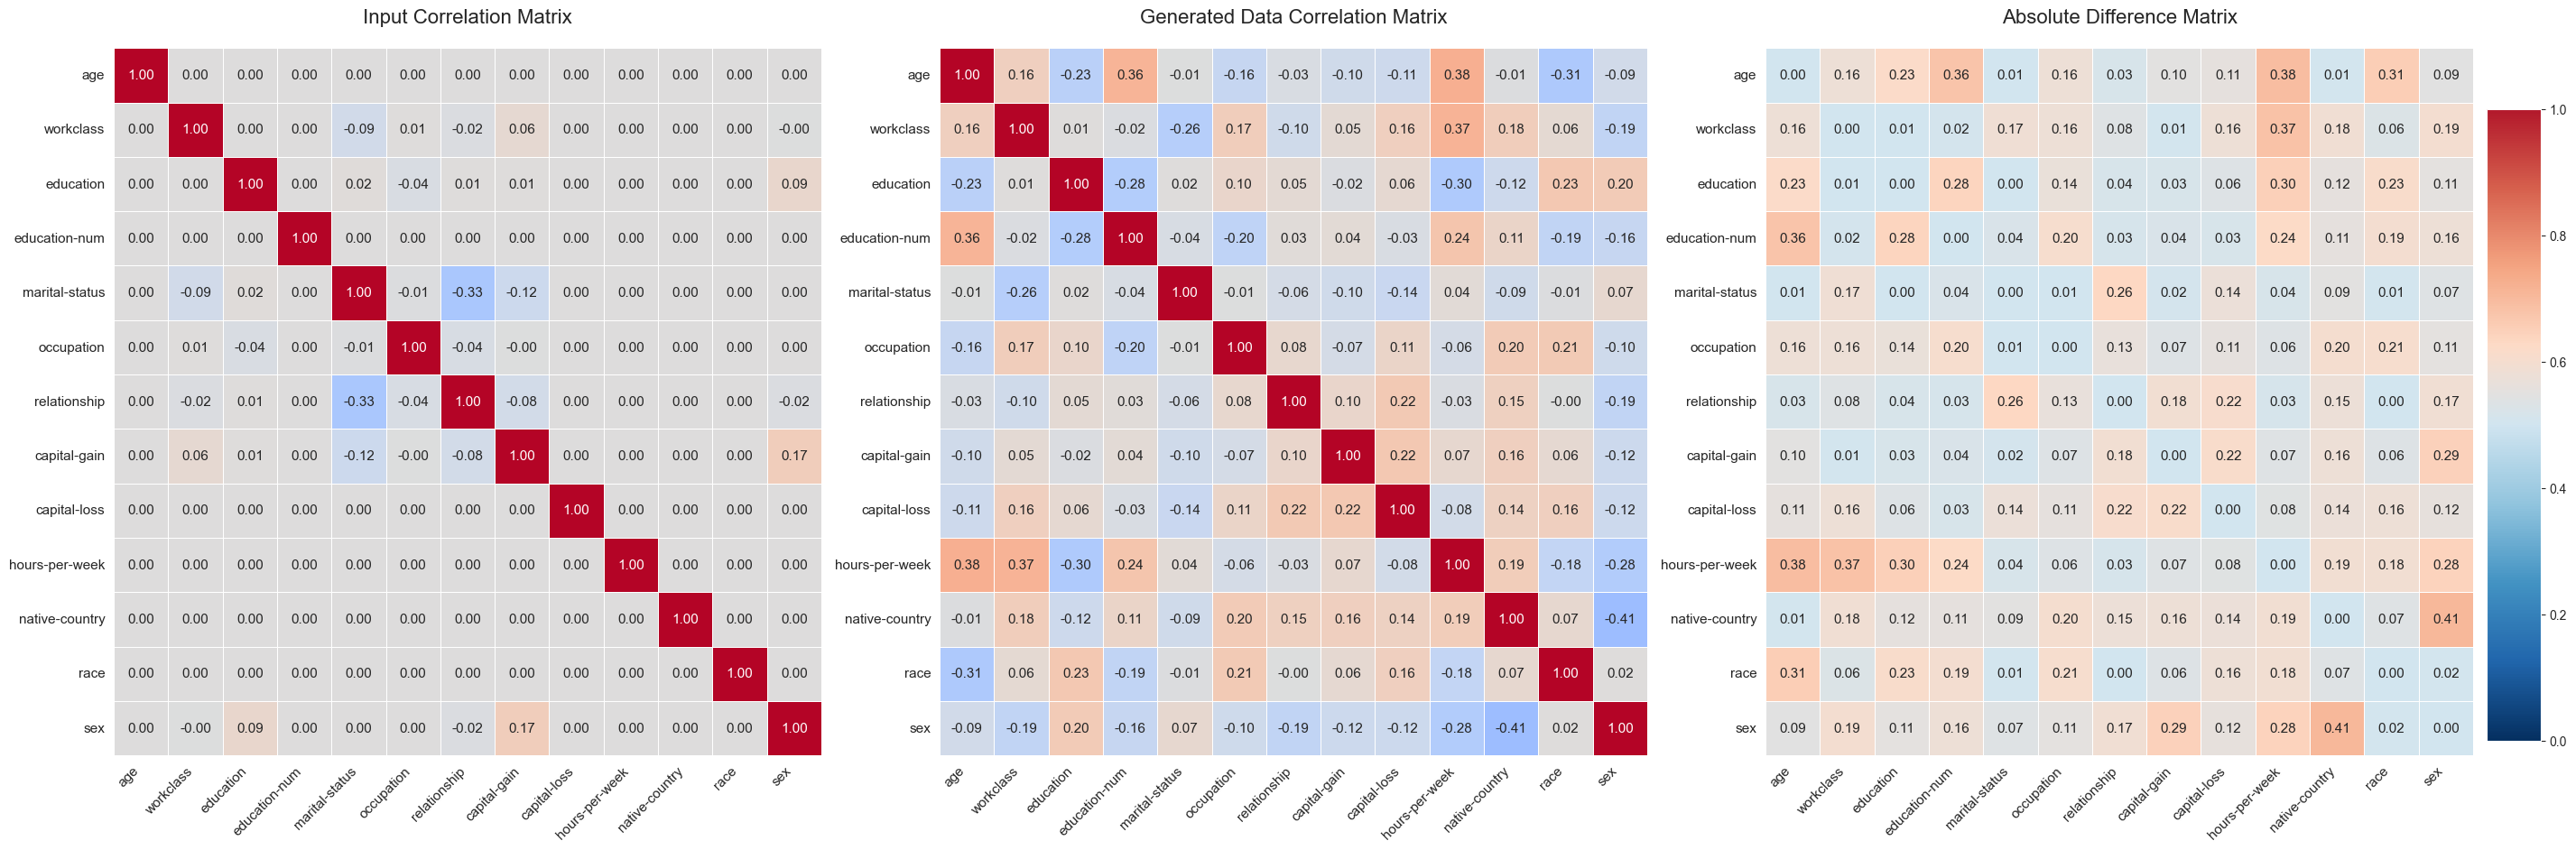


Matrix Similarity Metrics:
Mean absolute difference: 0.1241
Maximum absolute difference: 0.4117
Frobenius norm: 2.0902
Cosine similarity: 0.8639
Mean squared error: 0.0259
Correlation coefficient: 0.8545


In [34]:
plot_correlation_matrices(corr_matrix, data)

In [18]:
corr_matrix.shape, df2.shape

((13, 13), (2162, 13))